In [ ]:
import os
import re
import shutil
import string
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import losses

Download dataset:

In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84125825/84125825 [==============================] - 4s 0us/step


In [ ]:
dataset

'./aclImdb_v1'

Explore directories:

In [ ]:
os.listdir(dataset_dir)

['imdbEr.txt', 'train', 'README', 'test', 'imdb.vocab']

In [ ]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'urls_pos.txt',
 'labeledBow.feat',
 'unsup',
 'pos',
 'urls_neg.txt',
 'neg',
 'unsupBow.feat']

In [ ]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())


Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


Load data from directories using text_dataset_from_directory
---



In [ ]:
# remove the "unsup" folder to respect the folder structure
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [ ]:
# Create validation and training sets from the training folder
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset="training", 
    seed=seed)

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset="validation", 
    seed=seed)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
# create test dataset 
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [ ]:
len(raw_val_ds)*32

5024

In [ ]:
raw_train_ds.class_names

['neg', 'pos']

In [ ]:
raw_train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
# show one batch of reviews
for i in raw_train_ds.take(1):
  print(i)

(<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)',
       b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose persp

In [ ]:
# show one batch of corresponding labels
for i in raw_train_ds.take(1):
  print(i[1])

tf.Tensor([1 1 1 1 1 1 0 0 0 0 1 1 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 1 1 1 0 0], shape=(32,), dtype=int32)


In [ ]:
for text, label in raw_test_ds.take(1):
  for i in range(1):
    print(text[i])
    print(label[i])

tf.Tensor(b"*Criticism does mention spoilers*<br /><br />I rarely make user comments, but this is one movie I have no problem slandering. This movie stinks, and its mediocre of rating of 6 and a half stars is probably too high for such pulp. The Bone Collector is not at all the same calibre of film that Silence of the Lambs or Seven were, despite what its ad claims. This is a perfect example of how not to make a thriller. The pace of this movie was extremely slow- I actually left for about 10 minutes half-way through and came back at the exact scene with the exact same character with absolutely no progression (I refer to you the part where Angelina Jolie's character debates Denzel about cutting off a corpse' hands). The movie is not at all scary, but tries to compensate this with a love-subplot albeit sexy Angelina Jolie's character and Denzel Washington's. Of course, what you get is something comparable to that of the mentor-student relationship as seen in the brillian epic Silence of

Text pre-processing
---



In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Create the pre-processing layer:

In [ ]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Fit the pre-processing layer (vectorize_layer) to the training data


In [ ]:
# remove labels 
train_text = raw_train_ds.map(lambda x, y: x)

# fit the layer using the adapt method
vectorize_layer.adapt(train_text)

See result of the pre-processing layer:

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [ ]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))

first_review, first_label = text_batch[0], label_batch[7]

print("Review------------", first_review)
print("Label-------------", raw_train_ds.class_names[first_label])

print("Vectorized review----------------", vectorize_text(first_review, first_label))

Review------------ tf.Tensor(b'Belmondo is a tough cop. He goes after a big-time drug dealer (played by Henry Silva, normally a great villain - see "Sharky\'s Machine"; but here he is clearly dubbed, and because of that he lacks his usual charisma). He goes to the scuzziest places of Paris and Marseilles, asks for some names, beats up some people, gets the names, goes to more scuzzy places, asks for more names, beats up more people, etc. The whole movie is punch after punch after punch. It seems that the people who made it had no other ambition than to create the French equivalent of "Dirty Harry". Belmondo, who was 50 here, does perform some good stunts at the beginning; apart from those, "Le Marginal" is a violent, episodic, trite, shallow and forgettable cop movie. (*1/2)', shape=(), dtype=string)
Label------------- pos
Vectorized review---------------- (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[   1,    7,    4, 1233, 1021,   27,  261,  101,    4,    1, 1525,
        

In [ ]:
tf.expand_dims(first_review, -1)

<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'Belmondo is a tough cop. He goes after a big-time drug dealer (played by Henry Silva, normally a great villain - see "Sharky\'s Machine"; but here he is clearly dubbed, and because of that he lacks his usual charisma). He goes to the scuzziest places of Paris and Marseilles, asks for some names, beats up some people, gets the names, goes to more scuzzy places, asks for more names, beats up more people, etc. The whole movie is punch after punch after punch. It seems that the people who made it had no other ambition than to create the French equivalent of "Dirty Harry". Belmondo, who was 50 here, does perform some good stunts at the beginning; apart from those, "Le Marginal" is a violent, episodic, trite, shallow and forgettable cop movie. (*1/2)'],
      dtype=object)>

In [ ]:
print("48 ---> ",vectorize_layer.get_vocabulary()[48])

print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

48 --->  what
Vocabulary size: 10000


In [ ]:
vectorize_layer.get_vocabulary()[:10]

['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it']

Apply the pre-processing layer all the sets:

In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

Pipeline optimization:

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
for i in train_ds.take(1):
 print(i[0])

tf.Tensor(
[[9257   15   28 ...    0    0    0]
 [8657    3 6619 ...    0    0    0]
 [  33  252 1379 ...    0    0    0]
 ...
 [7472 9944   83 ...    0    0    0]
 [ 346  524   71 ...    0    0    0]
 [  10   62  455 ...    0    0    0]], shape=(32, 250), dtype=int64)


Create the model
---



In [ ]:
from keras.regularizers import l2

In [ ]:
embedding_dim = 16

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.5),
  #layers.GlobalAveragePooling1D(),
  layers.Bidirectional(tf.keras.layers.LSTM(32)),
  #tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(1e-3)),
  #layers.Dropout(0.5),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 172,625
Trainable params: 172,625
Non-trainable params: 0
_________________________________________________________________


Define loss function and optimizer:

In [ ]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

Train the model:

In [ ]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/20
625/625 [==============================] - 117s 181ms/step - loss: 0.6023 - binary_accuracy: 0.6779 - val_loss: 0.4363 - val_binary_accuracy: 0.8230
Epoch 2/20
625/625 [==============================] - 109s 175ms/step - loss: 0.4028 - binary_accuracy: 0.8304 - val_loss: 0.3552 - val_binary_accuracy: 0.8596
Epoch 3/20
625/625 [==============================] - 105s 168ms/step - loss: 0.2803 - binary_accuracy: 0.8917 - val_loss: 0.3655 - val_binary_accuracy: 0.8558
Epoch 4/20
625/625 [==============================] - 104s 167ms/step - loss: 0.2416 - binary_accuracy: 0.9110 - val_loss: 0.4069 - val_binary_accuracy: 0.8484
Epoch 5/20
625/625 [==============================] - 106s 169ms/step - loss: 0.2104 - binary_accuracy: 0.9227 - val_loss: 0.3834 - val_binary_accuracy: 0.8592
Epoch 6/20
625/625 [==============================] - 107s 171ms/step - loss: 0.1895 - binary_accuracy: 0.9316 - val_loss: 0.3666 - val_binary_accuracy: 0.8580
Epoch 7/20
625/625 [====================

Visulalize training performance:

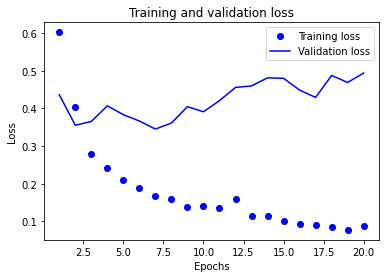

In [ ]:
history_dict = history.history

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Evaluate the model on test data:

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 38s 48ms/step - loss: 0.5780 - binary_accuracy: 0.8386
Loss:  0.5779941082000732
Accuracy:  0.8385999798774719


## Inference on new data



Export model:

In [ ]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 37s 44ms/step - loss: 0.5780 - accuracy: 0.8386
0.8385999798774719


Inference on new data:

In [ ]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - 1s 939ms/step


array([[0.6889007 ],
       [0.15609246],
       [0.06392251]], dtype=float32)